# SEGMENTASI CITRA: ALGORITMA WATERSHED
Proyek ini bertujuan untuk mempraktikkan materi Segmentasi Lanjut, khususnya Algoritma Watershed, pada citra ilustrasi/anime yang kompleks menggunakan bahasa pemrograman Python dan pustaka OpenCV. Segmentasi Watershed ideal untuk memisahkan objek yang saling bersentuhan (clumped objects).

Tujuan Implementasi
Untuk memahami dan mampu menerapkan Algoritma Watershed yang melibatkan langkah-langkah preprocessing dan morfologi kompleks, meliputi:

1. Thresholding dan Noise Reduction.

2. Penentuan Sure Foreground menggunakan Distance Transform.

3. Penentuan Sure Background menggunakan Dilasi.

4. Marker Labeling untuk area yang pasti dan area yang tidak diketahui (unknown region).

5. Penerapan algoritma Watershed.

# 1. Import Library dan Konfigurasi Awal

* import cv2	Pustaka utama untuk operasi pemrosesan citra.
* import numpy as np	Digunakan untuk manipulasi array, seperti membuat kernel morfologi.
* import matplotlib.pyplot as plt	Digunakan untuk menampilkan hasil visualisasi (plotting).


In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 2. Membaca dan Mengonversi Citra
Bertanggung jawab untuk memuat file gambar Anda dan mengonversinya ke format yang dibutuhkan oleh tahapan segmentasi.



In [11]:
FILE_PATH = 'Image.jpg'

# Membaca citra BGR (format default OpenCV)
image_color_bgr = cv2.imread(FILE_PATH)

if image_color_bgr is None:
    # Menghentikan eksekusi jika file tidak ditemukan
    raise FileNotFoundError(f"ERROR: File tidak ditemukan di {FILE_PATH} atau tidak dapat dibaca. Pastikan path dan nama file benar.")

# Konversi ke RGB (untuk tampilan Matplotlib) dan Grayscale (untuk pemrosesan)
image_color_rgb = cv2.cvtColor(image_color_bgr, cv2.COLOR_BGR2RGB)
image_gray = cv2.cvtColor(image_color_bgr, cv2.COLOR_BGR2GRAY)

print("Shape gambar:", image_gray.shape)

Shape gambar: (720, 1051)


# 3. Preprocessing (Blur dan Thresholding)
Langkah awal untuk membersihkan citra dan membuat segmentasi awal (biner).

* cv2.GaussianBlur Menerapkan filter penghalusan untuk mengurangi noise yang dapat menyebabkan over-segmentation.
* cv2.threshold Mengonversi citra menjadi biner. Otsu's Method memilih threshold optimal, dan THRESH_BINARY_INV memastikan objek foreground menjadi putih (nilai 255).

In [12]:
# --- 2. Preprocessing: Noise reduction (Gaussian Blur) ---
blur = cv2.GaussianBlur(image_gray, (5, 5), 0)

# --- 3. Thresholding dengan Otsu (Inverted) ---
ret, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# --- 4. Membuat Structuring Element (Kernel) ---
kernel = np.ones((3,3), np.uint8)

# 4. Operasi Morfologi untuk Penentuan Markers (Watershed)
Ini adalah langkah paling krusial untuk menghasilkan tiga region yang dibutuhkan Watershed: Sure Foreground, Sure Background, dan Unknown.

4.1. Opening dan Sure Background
* cv2.morphologyEx	Melakukan Opening (Erosi diikuti Dilasi) untuk menghilangkan noise kecil di luar objek.
* cv2.dilate	Memperluas (Dilasi) area Opening untuk mendapatkan area yang pasti bersih dari objek, yang kita sebut Sure Background.

In [13]:
# a. Opening: Menghilangkan noise di luar objek
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

# b. Sure Background (Dilasi pada Opening)
sure_bg = cv2.dilate(opening, kernel, iterations=3)

4.2. Distance Transform dan Sure Foreground
* cv2.distanceTransform Menghitung jarak piksel foreground ke background terdekat. Piksel dengan nilai tertinggi berada di inti objek.
* cv2.threshold Memilih piksel yang berada di inti objek (di atas ambang batas 0.7 * max()) sebagai Sure Foreground (marker yang pasti).
* np.uint8(sure_fg)PENTING: Mengubah tipe data Sure Foreground kembali ke uint8 agar kompatibel dengan operasi pengurangan cv2.subtract.

In [14]:
# c. Distance Transform
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)

# d. Sure Foreground (Threshold Distance Transform)
ret, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)
sure_fg = np.uint8(sure_fg)

4.3. Unknown Region
* cv2.subtract Menghitung selisih (Sure Background - Sure Foreground). Area yang tersisa adalah Unknown Region yang akan diisi oleh batas Watershed.

In [15]:
# e. Unknown Region
unknown = cv2.subtract(sure_bg, sure_fg)

# 5. Marker Labeling dan Eksekusi Watershed
Langkah terakhir: memberi label unik pada setiap objek dan menjalankan algoritma segmentasi.

* cv2.connectedComponents	Memberi label angka unik (1, 2, 3, ...) pada setiap objek di Sure Foreground.
* markers = markers + 1	Menggeser semua label foreground (1, 2, ...) menjadi (2, 3, ...), mengosongkan label 0.
* markers[unknown == 255] = 0	Memberi label 0 pada Unknown Region. Angka 0 ini yang menginstruksikan Watershed untuk membangun batas di sini.
* cv2.watershed	Menerapkan algoritma. Batas-batas objek yang dihasilkan diberi label -1.
* image_color_bgr[...]	Menandai piksel batas (-1) dengan warna PUTIH ([255, 255, 255]) pada citra asli.

In [16]:
# a. Marker labeling pada Sure Foreground
ret, markers = cv2.connectedComponents(sure_fg)
# b. Geser label agar background menjadi 1, dan 0 untuk unknown
markers = markers + 1
markers[unknown == 255] = 0

# c. Terapkan algoritma Watershed
markers_ws = cv2.watershed(image_color_bgr, markers)

# d. Tandai batas objek (markers == -1) dengan warna PUTIH (255, 255, 255 BGR)
image_color_bgr[markers_ws == -1] = [255, 255, 255]

# 6. Menampilkan Hasil Visualisasi
Menampilkan semua citra hasil tahapan proses dalam satu figure untuk memudahkan analisis.

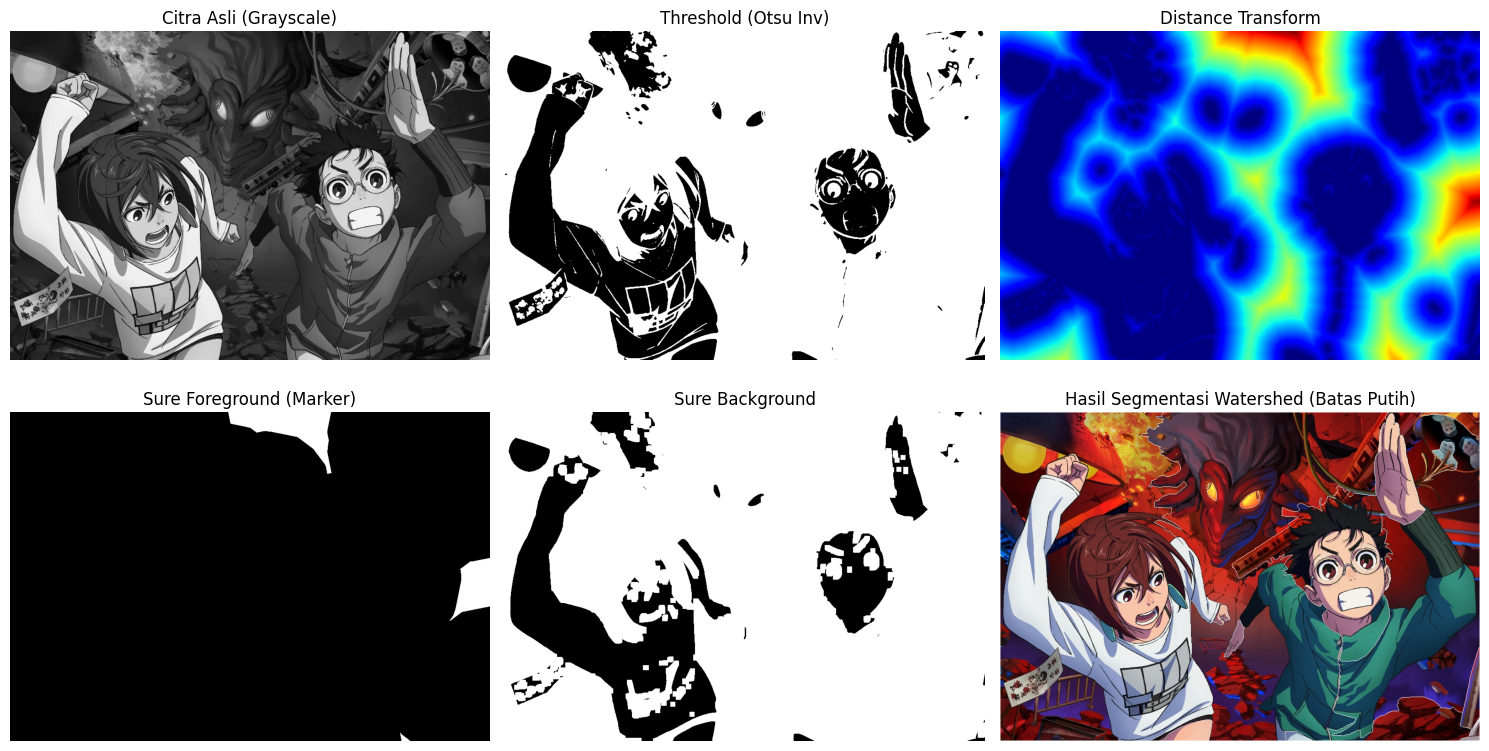

In [17]:
plt.figure(figsize=(15, 8))

titles = ["Citra Asli (Grayscale)", "Threshold (Otsu Inv)", "Distance Transform",
          "Sure Foreground (Marker)", "Sure Background", "Hasil Segmentasi Watershed (Batas Putih)"]
images = [image_gray, thresh, dist_transform, sure_fg, sure_bg, cv2.cvtColor(image_color_bgr, cv2.COLOR_BGR2RGB)]
cmaps = ['gray', 'gray', 'jet', 'gray', 'gray', None]

for i in range(len(images)):
    plt.subplot(2, 3, i + 1)
    plt.imshow(images[i], cmap=cmaps[i])
    plt.title(titles[i])
    plt.axis("off")

plt.tight_layout()
plt.show()

# Kesimpulan Hasil Segmentasi Watershed

Setelah menganalisis keenam visualisasi tahapan yang dihasilkan, dapat menyimpulkan bahwa implementasi Algoritma Watershed pada citra kompleks ini telah **berhasil secara efektif** memisahkan objek *foreground* utama (dua karakter) dari latar belakangnya, meskipun ada ruang untuk *tuning* parameter yang lebih optimal.

### 1. Analisis Preprocessing dan Thresholding (Tahap 1-3)

* **Citra Asli (Grayscale):** Kontras citra awal cukup baik antara objek utama dan latar belakang yang rumit.
* **Threshold (Otsu Inv):** Hasil *thresholding* Otsu menunjukkan bahwa objek utama (*foreground*) berhasil diisolasi dari *background*. Namun, ada beberapa detail kecil di *background* yang ikut menjadi putih, menunjukkan bahwa perlu mempertimbangkan *noise reduction* yang lebih agresif atau *tuning* lebih lanjut.

### 2. Penentuan Markers: Kunci Keberhasilan Segmentasi (Tahap 5)

Tahap ini membuktikan apakah *marker* yang diciptakan sudah tepat, sesuai teori *Region-based Segmentation*.

* **Distance Transform:** Visualisasi ini mengonfirmasi konsep **topografi *gradient***. Area berwarna panas (kuning/merah) adalah **inti-inti objek**, karena mereka memiliki jarak terjauh dari *background*. Inti inilah yang menjadi *Sure Foreground*.
* **Sure Foreground (Marker):** Karena menggunakan *threshold* yang cukup ketat (0.7 * dist_transform.max()), hasilnya adalah *marker* yang besar dan padat. Ukuran *marker* yang besar ini **penting** karena mencegah objek utama saya menjadi **over-segmented** (terpecah-pecah) oleh algoritma Watershed.
* **Sure Background:** Area putih di sini menunjukkan *region* yang **pasti** bukan merupakan objek utama. Selisihnya dengan *Sure Foreground* menjadi *Unknown Region*.

### 3. Hasil Segmentasi Watershed (Tahap 6 & 7)

* **Keberhasilan:** Segmentasi **berhasil memisahkan dua karakter** utama dari *background* yang sangat detail. Batas putih (piksel berlabel -1 yang stelah diset) berhasil melingkari masing-masing karakter secara individu. Ini menegaskan bahwa Watershed efektif untuk memisahkan objek yang saling berdekatan.
* **Isu Potensial (Kebutuhan Tuning):** Perhatikan *kernel* Gaussian Blur ((5, 5)) yang relatif besar mungkin terlalu agresif. Ini menyebabkan beberapa **detail halus** (seperti antara tangan dan tubuh) terlewat, dan batasnya menjadi sedikit kasar. Ini akan menjadi fokus *tuning* selanjutnya.

Secara keseluruhan, Algoritma Watershed yang terapkan telah sukses mencapai tujuan proyek dengan mengaplikasikan konsep penentuan *marker* untuk segmentasi objek *foreground*.